# Hit and run sampling

Sampling the feasible space of the model allows you to gain a realistic
insight into the distribution of the flow and its probabilistic nature, often
better describing the variance and correlations of the possible fluxes better
(but more approximately) than e.g. [flux variability analysis](06_fva.md).

COBREXA supports a variant of hit-and-run sampling adjusted to the
complexities of metabolic models; in particular, it implements a version
where the next sample (and indirectly, the next run direction) is generated
as an affine combination of the samples in the current sample set. This gives
a result similar to the artificially centered hit-and-run sampling, with a
slightly (unsubstantially) different biases in the generation of the next
hits.

As always, we start by loading everything that is needed:

In [1]:
!isfile("e_coli_core.xml") &&
    download("http://bigg.ucsd.edu/static/models/e_coli_core.xml", "e_coli_core.xml")

using COBREXA, GLPK

model = load_model("e_coli_core.xml")

Metabolic model of type SBMLModel
sparse([8, 10, 21, 43, 50, 51, 8, 9, 6, 12  …  33, 66, 68, 72, 23, 26, 33, 72, 22, 33], [1, 1, 1, 1, 1, 1, 2, 2, 3, 3  …  93, 93, 93, 93, 94, 94, 94, 94, 95, 95], [-1.0, 1.0, -1.0, 1.0, -1.0, 1.0, 1.0, -1.0, -1.0, 1.0  …  1.0, -1.0, 1.0, -1.0, -1.0, 1.0, 1.0, -1.0, -1.0, 1.0], 72, 95)
Number of reactions: 95
Number of metabolites: 72


The sampling procedure requires a set of "seed" points that will form the
basis for the first iteration of runs. This is commonly called a warm-up. You
can generate these points manually with any method of choice, or you can use
the COBREXA implementation of warmup that uses the extreme edges of the
polytope, similarly to the way used by flux variability analysis:

In [2]:
warmup_points = warmup_from_variability(model, GLPK.Optimizer)

95×190 Matrix{Float64}:
 -20.0          -20.0          …     0.0             0.0
 -20.0          -20.0                0.0             0.0
   0.0            0.0                0.0             0.0
  -1.55771e-14   -1.55771e-14        0.0            10.0
  -1.82795e-14   -1.82795e-14        0.0            10.0
   0.0            0.0          …     0.0             0.0
   5.07605e-15    5.07605e-15       10.0            -1.20387e-12
   5.83169e-15    5.83169e-15        0.0             0.0
   0.0            0.0                0.0           -10.0
   2.63641e-15    2.63641e-15        0.0             0.0
   ⋮                           ⋱                  
   0.0            0.0               -4.57823e-13    -3.44052e-13
   3.16102e-15    3.16102e-15       -4.57823e-13    -3.44052e-13
  -1.04907e-14   -1.04907e-14     1000.0          1000.0
  -4.77335e-15   -4.77335e-15        0.0             0.0
  -3.16854e-15   -3.16854e-15  …    20.0            -1.95399e-13
  -9.32587e-14   -9.32587e-14      243

This generates a matrix of fluxes, where each column is one sample point, and
rows correspond to the reactions in the model.

With this, starting the sampling procedure is straightforward:

In [3]:
samples = affine_hit_and_run(model, warmup_points)

95×950 Matrix{Float64}:
  -1.66909    -2.18493    -2.26181   …   -2.03885    -1.8475     -2.46558
  -0.470124   -0.430387   -0.617061      -0.553997   -0.6049     -0.802518
  -1.57443    -2.32797    -1.03189       -1.45541    -1.8394     -1.57826
   8.72508     7.92127     7.66237        9.05437     8.46192     6.27915
   8.72508     7.92127     7.66237        9.05437     8.46192     6.27915
  -1.57443    -2.32797    -1.03189   …   -1.45541    -1.8394     -1.57826
  12.7365      6.94142    16.8438        10.248       9.4414      3.07769
   4.55669     4.5086      3.61501        4.47861     4.48705     3.54988
  -0.706878   -0.454369   -0.942265      -1.08006    -0.924169   -0.724058
  -1.19896    -1.75454    -1.64475       -1.48485    -1.2426     -1.66306
   ⋮                                 ⋱                          
  11.1703     14.2109      5.96447       13.0883     10.0192      6.78829
  12.0925     14.8723      7.45343       13.5965     10.7236      7.40941
 360.742     254.428 

As seen above, the result again contains 1 sample per column, with reactions
in the same order with rows as before. To get a different sample, you can
tune the parameters the function. `sample_iters` allows you to specify the
iterations at which you want the current sample to be collected and reported
-- by default, that is done 5 times on each 100th iteration. In the example
below, we catch the samples in 10 iterations right after the 200th iteration
passed.  Similarly, to avoid possible degeneracy, you can choose to run more
hit-and-run batch chains than 1, using the `chains` parameters. The total
number of points collected is the number of points in warmup times the number
of sample-collecting iterations times the number of chains.

In [4]:
samples = affine_hit_and_run(model, warmup_points, sample_iters = 201:210, chains = 2)

95×3800 Matrix{Float64}:
  -1.83943    -2.35747    -1.27553    …   -2.30409    -1.79585    -2.11809
  -0.884734   -1.18704    -0.0266316      -0.92447    -0.899217   -0.633379
  -0.900053   -0.914011   -0.816364       -1.36337    -1.23206    -1.42901
   9.67229     8.86613    12.029           7.39692     7.87746     7.01543
   9.67229     8.86613    12.029           7.39692     7.87746     7.01543
  -0.900053   -0.914011   -0.816364   …   -1.36337    -1.23206    -1.42901
  10.7787      8.69312     6.35625        11.2565     14.7761      7.13841
   6.15562     5.92554     6.82139         4.51902     5.26378     3.73543
  -0.552501   -0.749031   -0.296984       -0.889356   -0.817638   -0.95307
  -0.954697   -1.17043    -1.2489         -1.37962    -0.896631   -1.48471
   ⋮                                  ⋱                          
  13.5435     13.547      13.4649          9.40663    10.1687     11.3463
  14.1685     14.217      14.149          10.7795     11.4346     12.8174
 441.007  

## Visualizing the samples

Samples can be displayed very efficiently in a scatterplot or a density plot,
which naturally show correlations and distributions of the fluxes:

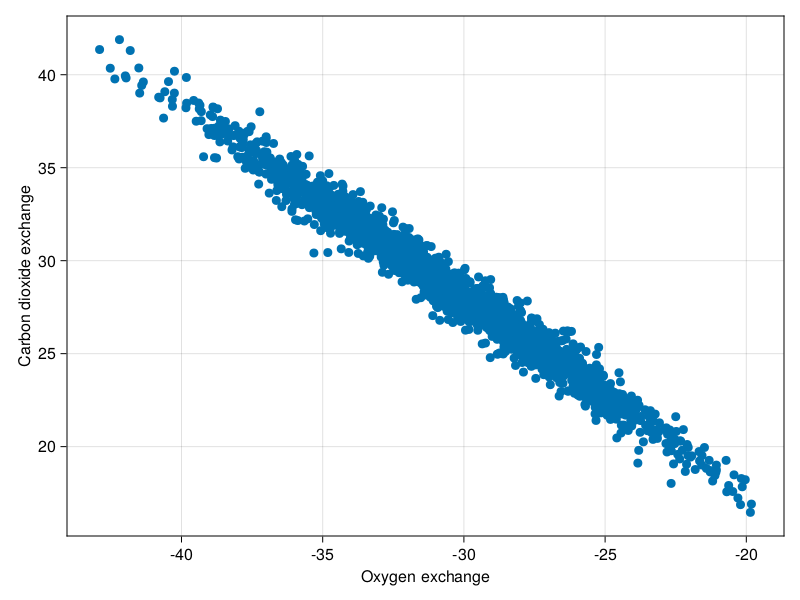

In [5]:
using CairoMakie

o2, co2 = indexin(["R_EX_o2_e", "R_EX_co2_e"], reactions(model))

scatter(
    samples[o2, :],
    samples[co2, :];
    axis = (; xlabel = "Oxygen exchange", ylabel = "Carbon dioxide exchange"),
)

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*